<a href="https://colab.research.google.com/github/vanshs64/biochem-3AB3/blob/main/ML_Antibiotics_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Antibiotic Discovery Assignment.
**3AB3 - Antibiotics.**

Your goal is to preprocesses your training data. Then, train a random forest model using your processed data. You will then run predictions on a set of 2,925 molecules. You will be calculating how similar these molecules are to known antibiotics to identify novel antibiotics. Finally, you will provide a final set of molecules that you would prioritize to be tested in the lab based on what you have learned from this tutorial series.

Reminder that LLMs such as ChatGPT are very effective at writing and editing code! Please use the Google Colab provided as a starting point.


#Part 1: Data preprocessing

In [1]:
#Download training data

!wget https://raw.githubusercontent.com/GaryLiu152/3AB3_Antibiotics/main/final_assignment_data/s_aureus_training_data.csv -O 'S_Aureus_Training_Data.csv'

--2025-03-12 15:49:29--  https://raw.githubusercontent.com/GaryLiu152/3AB3_Antibiotics/main/final_assignment_data/s_aureus_training_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174893 (171K) [text/plain]
Saving to: ‘S_Aureus_Training_Data.csv’

S_Aureus_Training_D 100%[===================>] 170.79K  --.-KB/s    in 0.04s   

2025-03-12 15:49:29 (4.49 MB/s) - ‘S_Aureus_Training_Data.csv’ saved [174893/174893]



In [2]:
#Install necessary packages
!pip install pandas
!pip install np
!pip install matplotlib

!pip install rdkit
!pip install scikit-learn
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install tqdm

!git clone https://github.com/bp-kelley/descriptastorus

  Preparing metadata (setup.py) ... done
  Created wheel for np: filename=np-1.0.2-py3-none-any.whl size=13658 sha256=e85570e4adc7292f92d33853a52120512ff901c8c7b9d5539d1fd9bcdedf5c02
  Stored in directory: /root/.cache/pip/wheels/19/20/42/6ee214e617f78123903f603524d662ac6fa14154c3027fd992
Successfully built np
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 8.4 MB/s eta 0:00:00
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-egao79uk
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-egao79uk
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9a190343bcd3cfd35142d378d952613bcac40797
  Preparing metadata (setup.py) ... done
  Created wheel for descriptastorus: filename=descriptastorus-2.7.0.3-py3-none-any.whl size=1082894 sha256=47f5e3b60c791d7024776b47fc115cc8b69f8348af230253f39ebff93405a664
  Stored in directory: /tmp/pip-ephem-wheel-cache-yuxkurnj/wheels/a5/37/b0/b

In [3]:
#Import Libraries
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
#Read and import data
file_path = r"/content/S_Aureus_Training_Data.csv"
pp = pprint.PrettyPrinter(indent=4)

df = pd.read_csv(file_path)
pp.pprint(df)


                                                 SMILES  96-Plate 96-Well  \
0     CC(C)=CC[C@@]12C3=CC=C(O)C=C3O[C@]1(O)C(=O)C1=...     45292     A02   
1     O=C(C1=CC(=O)C2=CC(F)=CC=C2O1)NC1CCN(CC2=CC=C3...     45292     A03   
2                  O=CN1C(=O)/C(=C/C2=CC=C3OCOC3=C2)CC1     45292     A04   
3     O=C(OCCCC)NS(=O)(C1=C(C2=CC=C(CN3C=CN=C3)C=C2)...     45292     A05   
4        CCC1=C(C(=O)OC)N=CC2=C1C1=C(C=C(OC)C(OC)=C1)N2     45292     A06   
...                                                 ...       ...     ...   
2065  O=C(C(C1=CC=CC=C1)C(OC1=CC=C2C(=C1)CCC2)=O)N[C...     45325     H07   
2066  O=C1C2=C(C=CC=C2)C(CC2=CC(F)=NC=C2)(CC2=CC(F)=...     45325     H08   
2067  O=C1NC2=C(S1)C=C([C@H](C)C1=NN(C3=CC=C(OCCO)C=...     45325     H09   
2068                 O=C(OC)CCCCCCCC1C(CC2C(CCCCC)C2)C1     45325     H10   
2069  O=S(C1=C(NC2=C3CCNC3=NC(NC3=C(OC)C=C(N4CCC(N5C...     45325     H11   

      16h Raw R1  16h Raw R2  
0          0.057       0.048  
1          1.

In [5]:
# Extra (visualization)

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Assuming 'smiles' is the column name containing SMILES strings
try:
    mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES'][:5]]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, legends=df['16h Raw R1'][:5].astype(str).to_list(), subImgSize=(400,400))
except KeyError:
    print("Error: 'smiles' column not found in the DataFrame.")
except Exception as e:
    print(f"An error occurred: {e}")


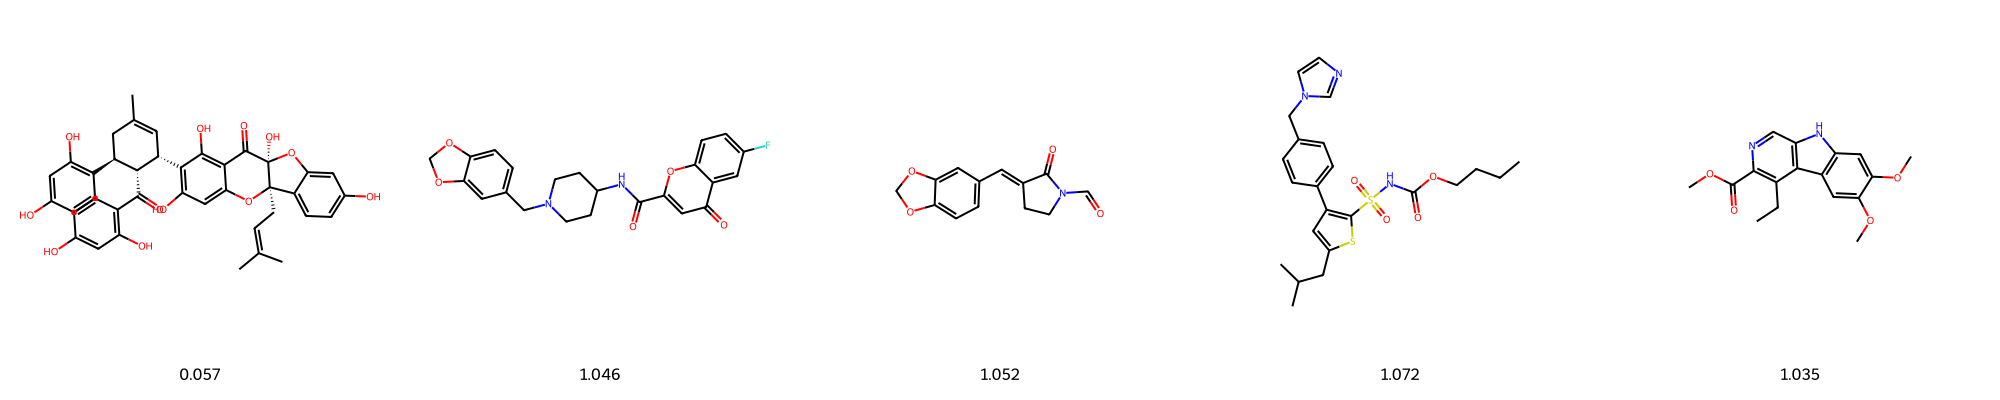

In [6]:
  img #Show image with Rep 1 OD Value reads underneath.

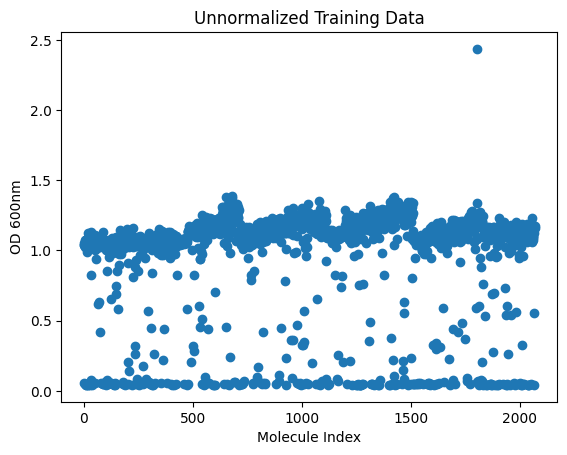

In [46]:
#Create new column for the average of the 16h OD (optical density) measurements
df['16h Raw Mean'] = df[['16h Raw R1', '16h Raw R2']].mean(axis=1)

#Plot unnormalized data
plt.scatter(df.index, df['16h Raw Mean'])

# Set plot labels and title
plt.xlabel('Molecule Index')
plt.ylabel('OD 600nm')
plt.title('Unnormalized Training Data')

plt.show()
# Show the plot

In [8]:
#Calculate interquartile means per plate
iqms= []
for row in df.index:
    same_plate_rows = df[df['96-Plate'] == df['96-Plate'][row]]


    # mathematical quartiles
    q1 = np.percentile(same_plate_rows['16h Raw Mean'], 25)
    q3 = np.percentile(same_plate_rows['16h Raw Mean'], 75)


    iqm = same_plate_rows.loc[same_plate_rows['16h Raw Mean'].between(q1, q3, inclusive='neither'), '16h Raw Mean'].mean()
    iqms.append(iqm)

df['Plate_IQM'] = iqms

In [10]:
#Normalize raw reads using Plate IQMs. Then, creates a new column to hold normalized data
df['16h Normalized'] = df['16h Raw Mean'] / df['Plate_IQM']

#pp.pprint(df)
#df.head(100)

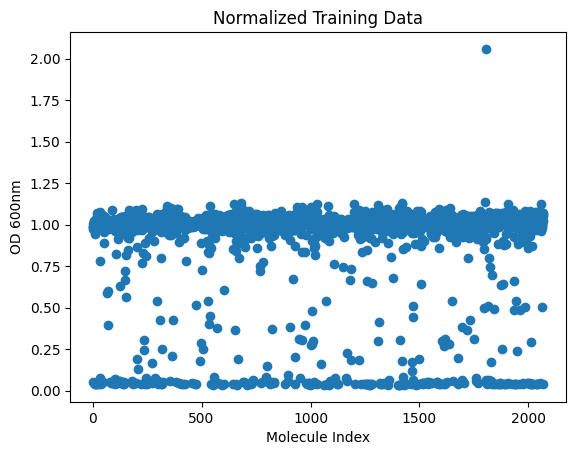

In [11]:
#Plot normalized data
plt.scatter(df.index, df['16h Normalized'])

# Set plot labels and title
plt.xlabel('Molecule Index')
plt.ylabel('OD 600nm')
plt.title('Normalized Training Data')

plt.show()

Normalized, Standard Deviation:  0.3064852833303095
Normalized, Mean:  0.8861230293395237


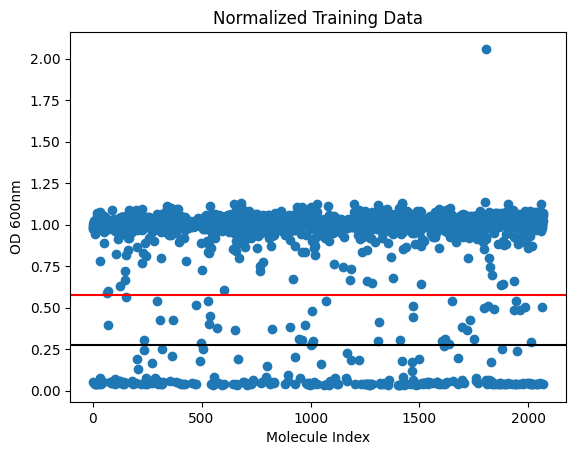

In [12]:
#Drawing and showing hit cut offs using standard deviations
std_dev = df['16h Normalized'].std()

mean = df['16h Normalized'].mean()

print("Normalized, Standard Deviation: ", std_dev)
print("Normalized, Mean: ", mean)

mean_1std = df['16h Normalized'].mean() - std_dev

mean_2std = df['16h Normalized'].mean() - (2 * std_dev)


#Plot normalized data
plt.scatter(df.index, df['16h Normalized'])

# Set plot labels and title
plt.xlabel('Molecule Index')
plt.ylabel('OD 600nm')
plt.title('Normalized Training Data')

plt.axhline(y= mean_1std, color = 'red', label = 'Mean - 1 std dev')
plt.axhline(y= mean_2std, color = 'black', label = 'Mean - 2 std dev')

plt.show()

In [13]:
#Binarize data using Mean - 1 standard deviation as a cut off. 1 Represents a 'hit', 0 represents a 'non-hit'
df['antibiotic_hits'] = (df['16h Normalized'] < mean_1std).astype(int)

print('Number of hits = ', df['antibiotic_hits'].sum())
print('Number of non-hits = ', len(df) - df['antibiotic_hits'].sum())

Number of hits =  270
Number of non-hits =  1800


In [14]:
#Remove rows not containing SMILES entries.
print('All rows =', len(df))
df = df.dropna(subset = ['SMILES'])
print('All rows with SMILES  =', len(df))

print('Number of hits = ', df['antibiotic_hits'].sum())
print('Number of non-hits = ', len(df) - df['antibiotic_hits'].sum())

All rows = 2070
All rows with SMILES  = 2070
Number of hits =  270
Number of non-hits =  1800


In [15]:
#Save your normalized and processed data.
df.to_csv(r"/content/S_Aureus_Normalized.csv", index = False)

In [16]:
%%capture
#Sanitize your data (remove unprocessable SMILEs entries)
from descriptastorus.descriptors import rdNormalizedDescriptors
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import SaltRemover

data = pd.read_csv('S_Aureus_Normalized.csv')
remover = SaltRemover.SaltRemover(defnData="[Cl,Br]") # remove salts from molecule instances to process pure chemicals with their og SMILES
def canonicalize_smiles(smiles:str):
  try:
    mol = Chem.MolFromSmiles(smiles)
    stripped = remover.StripMol(mol)
    Chem.RemoveStereochemistry(stripped)
    return(Chem.MolToSmiles(stripped))
  except:
    return None
data['SMILES'] = data['SMILES'].apply(canonicalize_smiles)
data = data.dropna(subset = ['SMILES'])

In [17]:
print(f'Pre-sanitized data length = {len(data)}')
data = data.dropna(subset = ['SMILES'])
print(f'Post-sanitized data length = {len(data)}')

Pre-sanitized data length = 2066
Post-sanitized data length = 2066


Here we're going to do some brief visualizations of our training data. You'll find no singular property can adquetly distinguish hits and non hits.

In [18]:
from rdkit.Chem import Descriptors

def calculate_features(smiles):
  mol = Chem.MolFromSmiles(smiles)
  if mol is not None:
    tpsa = Descriptors.TPSA(mol)
    logp = Descriptors.MolLogP(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    h_donors = Descriptors.NumHDonors(mol)
    mol_w = Descriptors.MolWt(mol)
    return tpsa, logp, h_acceptors, h_donors, mol_w
  else:
    return None, None, None, None, None

features = []
for smiles in tqdm(data['SMILES']):
    feature = calculate_features(smiles)
    features.append(feature)

data[['TPSA', 'logP', 'H_acceptors', 'H_donors', 'mol_w']] = pd.DataFrame(features, index= data.index)

100%|██████████| 2066/2066 [00:06<00:00, 296.49it/s]


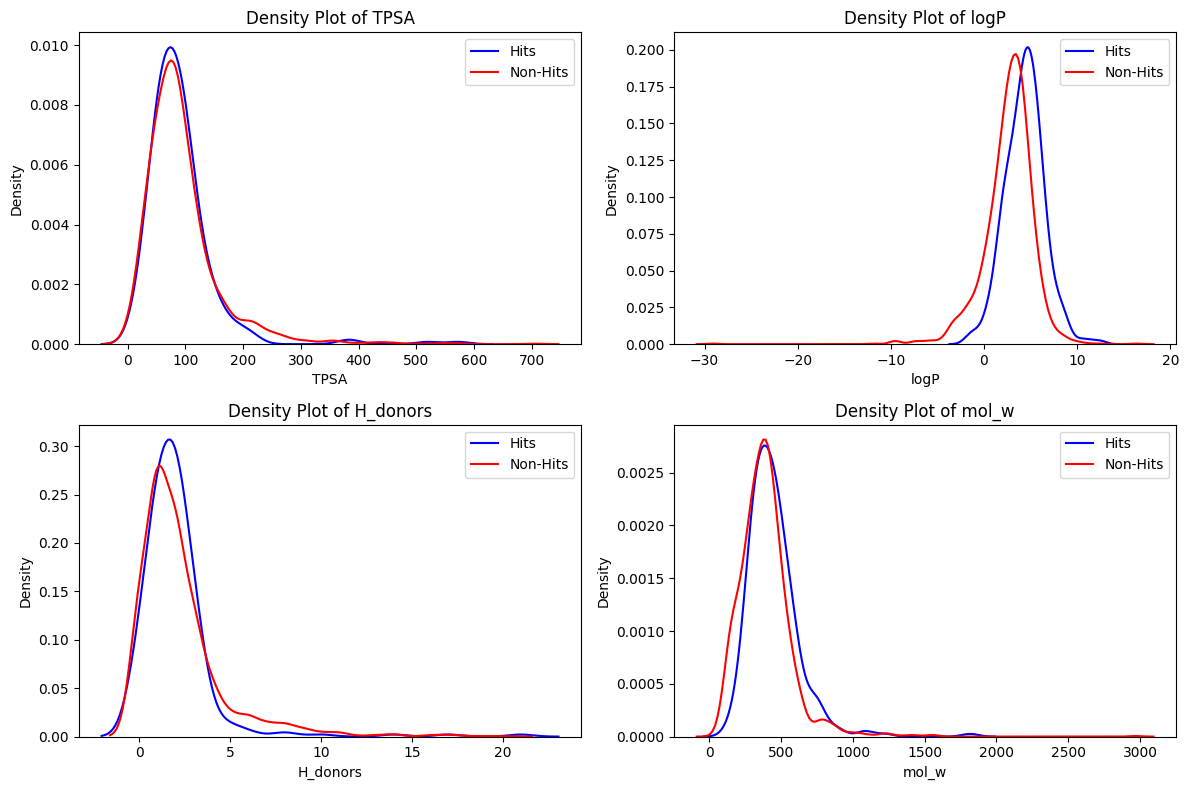

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a DataFrame called 'data' and you have columns named 'TPSA', 'logP', 'H_acceptors', 'H_donors', and 'antibiotic_hits'
# Replace 'your_file.csv' with the actual path to your data file
# data = pd.read_csv('your_file.csv')


# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define the properties and their corresponding axes
properties = ['TPSA', 'logP', 'H_donors', 'mol_w']
ax_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]


for i, property in enumerate(properties):
    ax = axes[ax_indices[i]]

    # Plot density plots for hits and non-hits
    sns.kdeplot(data[data['antibiotic_hits'] == 1][property], ax=ax, label='Hits', color='blue')
    sns.kdeplot(data[data['antibiotic_hits'] == 0][property], ax=ax, label='Non-Hits', color='red')

    # Set labels and title for each subplot
    ax.set_xlabel(property)
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot of {property}')
    ax.legend()

plt.tight_layout()
plt.show()

100%|██████████| 2066/2066 [00:03<00:00, 559.65it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


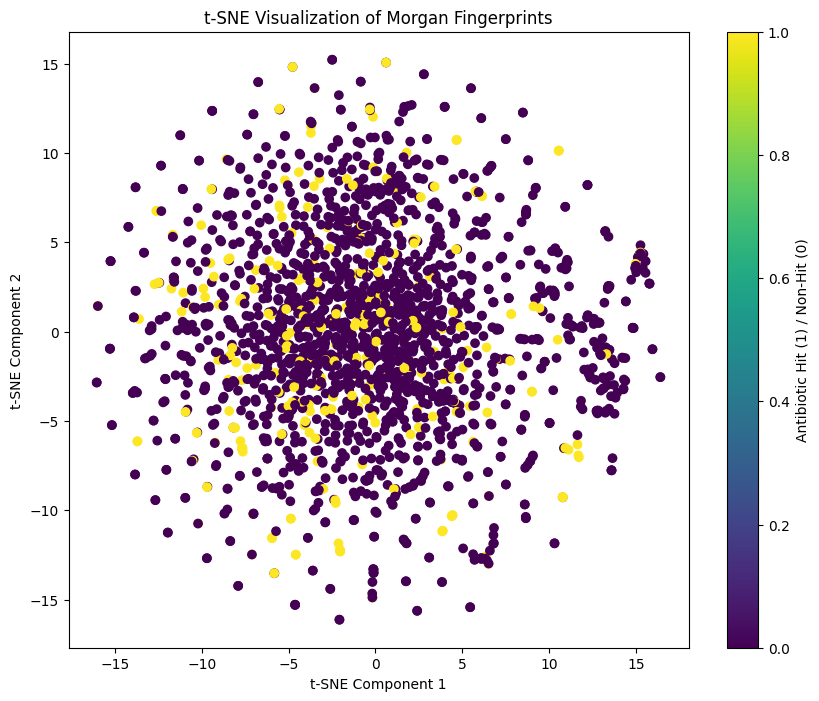

In [20]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate Morgan fingerprints
fingerprints = []
for smiles in tqdm(data['SMILES']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        fingerprints.append(fp)
    else:
        fingerprints.append(None)

# Remove entries with invalid fingerprints
data = data[pd.notna(data['SMILES'])]
fingerprints = [fp for fp in fingerprints if fp is not None];
data = data[0:len(fingerprints)]

# Convert fingerprints to numpy array
X = np.array(fingerprints)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data['antibiotic_hits'])
plt.colorbar(label='Antibiotic Hit (1) / Non-Hit (0)')
plt.title('t-SNE Visualization of Morgan Fingerprints')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


#Part 2: Model training

In [21]:
#Calculate and save RDKit features
features_generator = rdNormalizedDescriptors.RDKit2DNormalized()

feature_vectors = []
for smile in tqdm(data['SMILES'], total = len(data), desc= 'Calculating Features'):
  mol_features = features_generator.process(smile)[1:]
  feature_vectors.append(mol_features)

assert len(feature_vectors) == len(data)
data['normalized_features'] = feature_vectors

Calculating Features: 100%|██████████| 2066/2066 [02:12<00:00, 15.58it/s]


In [22]:
# prompt: print the first 100 lines of data[] from earlier

print(data[:100])


                                               SMILES  96-Plate 96-Well  \
0   CC(C)=CCC12Oc3cc(O)c(C4C=C(C)CC(c5ccc(O)cc5O)C...     45292     A02   
1   O=C(NC1CCN(Cc2ccc3c(c2)OCO3)CC1)c1cc(=O)c2cc(F...     45292     A03   
2                     O=CN1CCC(=Cc2ccc3c(c2)OCO3)C1=O     45292     A04   
3   CCCCOC(=O)NS(=O)(=O)c1sc(CC(C)C)cc1-c1ccc(Cn2c...     45292     A05   
4           CCc1c(C(=O)OC)ncc2[nH]c3cc(OC)c(OC)cc3c12     45292     A06   
..                                                ...       ...     ...   
95  Cc1ccc(NC(=O)c2ccc3c(c2)OCCO3)cc1NC(=O)c1ccc2n...     45293     B08   
96  COc1nccnc1NS(=O)(=O)c1ccc(NC(=O)C=Cc2ccc([N+](...     45293     B09   
97  CN(C)c1cccc2c(S(=O)(=O)NC(CCC(=O)NC(CS)C(=O)NC...     45293     B10   
98                       Oc1ccc(C2COc3cc(O)ccc3C2)cc1     45293     B11   
99  COc1ccc(F)c(F)c1C(=O)c1cnc(NC2CCN(S(C)(=O)=O)C...     45293     C02   

    16h Raw R1  16h Raw R2  16h Raw Mean  Plate_IQM  16h Normalized  \
0        0.057       0.048  

In [23]:
#Train a random forest model using sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare the data
Features = data['normalized_features']
Features = pd.DataFrame(data['normalized_features'].tolist(), columns=[f'normalized_features_{i+1}' for i in range(200)])
Features = Features.fillna(0)
Labels = data['antibiotic_hits']

#Split data into 80% training set and 20% test split.
Features_train, Features_test, Labels_train, Labels_test = train_test_split(Features, Labels, test_size=0.2, random_state= 0)

# Create and train the model
model = RandomForestClassifier(n_estimators=500, random_state= 0)
model.fit(Features_train, Labels_train)



RandomForestClassifier(n_estimators=500, random_state=0)

In [24]:
# Make predictions on the test set for performance metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


#Create predictions using each of the 500 decision trees
predictions = np.array([tree.predict(Features_test) for tree in model.estimators_])
predictions = np.mean(predictions, axis=0)

In [25]:
# These are all the predictions of your test set! Notice how they range from 0-1
print(predictions)
print(len(predictions))

print(len(Features_test))

[0.068 0.088 0.046 0.2   0.04  0.398 0.466 0.122 0.512 0.168 0.122 0.112
 0.278 0.13  0.014 0.002 0.206 0.146 0.082 0.754 0.156 0.028 0.088 0.124
 0.006 0.056 0.022 0.346 0.416 0.03  0.246 0.106 0.118 0.296 0.03  0.12
 0.14  0.018 0.012 0.49  0.004 0.138 0.142 0.068 0.072 0.106 0.15  0.016
 0.016 0.516 0.244 0.006 0.074 0.112 0.008 0.048 0.304 0.334 0.194 0.064
 0.006 0.296 0.156 0.126 0.072 0.376 0.062 0.114 0.22  0.388 0.04  0.476
 0.512 0.216 0.198 0.074 0.    0.06  0.14  0.114 0.412 0.162 0.166 0.116
 0.11  0.12  0.072 0.082 0.026 0.396 0.11  0.098 0.072 0.026 0.156 0.106
 0.02  0.168 0.192 0.05  0.058 0.418 0.306 0.062 0.21  0.106 0.336 0.172
 0.19  0.426 0.24  0.13  0.49  0.288 0.232 0.09  0.384 0.07  0.174 0.282
 0.098 0.022 0.088 0.244 0.284 0.126 0.356 0.006 0.13  0.282 0.118 0.222
 0.068 0.124 0.114 0.076 0.072 0.054 0.042 0.07  0.046 0.226 0.14  0.176
 0.054 0.086 0.09  0.088 0.074 0.146 0.106 0.03  0.094 0.1   0.242 0.108
 0.054 0.054 0.102 0.268 0.106 0.144 0.328 0.008 0.1

In [26]:
#Calculate Confusion Matrix using a threshold 0.5
#Values >0.5 are given a positive prediction (Pred)
#"Label" is the antibiotic label we obtained from screening

#The confusion matrix compares the model's predictions (Pred) and the
#true label (Label)

from sklearn.metrics import confusion_matrix, accuracy_score
cm_labels_col, cm_labels_row = ['Pred 0', 'Pred 1'] , ['Label 0', 'Label 1']
def binarize_prediction(prediction, threshold):
  if prediction >= threshold:
    return 1
  else:
    return 0

threshold = 0.3
predictions_binarized = [binarize_prediction(prediction, threshold=threshold) for prediction in predictions]
# Calculate the confusion matrix
cm = confusion_matrix(Labels_test, predictions_binarized)
cm = pd.DataFrame(cm, index=cm_labels_row, columns=cm_labels_col)
print(f"\n Confusion Matrix, Threshold = {threshold}:")
print(cm)

tn, fp, fn, tp = confusion_matrix(Labels_test, predictions_binarized).ravel()

print("True Positive Rate (TPR):", tp/(tp+fn))
print("False Positive Rate (FPR):", fp/(fp+tn))
print("Accuracy:", accuracy_score(Labels_test, predictions_binarized))


 Confusion Matrix, Threshold = 0.3:
         Pred 0  Pred 1
Label 0     329      42
Label 1      27      16
True Positive Rate (TPR): 0.37209302325581395
False Positive Rate (FPR): 0.11320754716981132
Accuracy: 0.8333333333333334


In [27]:
for threshold in np.arange(0 , 1.1, 0.1):
  threshold = round(threshold, 1)
  predictions_binarized = [binarize_prediction(prediction, threshold=threshold) for prediction in predictions]
  # Calculate the confusion matrix
  cm = confusion_matrix(Labels_test, predictions_binarized)
  cm = pd.DataFrame(cm, index=cm_labels_row, columns=cm_labels_col)
  print(f"\n Confusion Matrix, Threshold = {threshold}:")
  print(cm)

  tn, fp, fn, tp = confusion_matrix(Labels_test, predictions_binarized).ravel()

  print("True Positive Rate (TPR):", tp/(tp+fn))
  print("False Positive Rate (FPR):", fp/(fp+tn))
  print("Accuracy:", accuracy_score(Labels_test, predictions_binarized))


 Confusion Matrix, Threshold = 0.0:
         Pred 0  Pred 1
Label 0       0     371
Label 1       0      43
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 1.0
Accuracy: 0.10386473429951691

 Confusion Matrix, Threshold = 0.1:
         Pred 0  Pred 1
Label 0     176     195
Label 1       2      41
True Positive Rate (TPR): 0.9534883720930233
False Positive Rate (FPR): 0.5256064690026954
Accuracy: 0.5241545893719807

 Confusion Matrix, Threshold = 0.2:
         Pred 0  Pred 1
Label 0     289      82
Label 1      18      25
True Positive Rate (TPR): 0.5813953488372093
False Positive Rate (FPR): 0.2210242587601078
Accuracy: 0.7584541062801933

 Confusion Matrix, Threshold = 0.3:
         Pred 0  Pred 1
Label 0     329      42
Label 1      27      16
True Positive Rate (TPR): 0.37209302325581395
False Positive Rate (FPR): 0.11320754716981132
Accuracy: 0.8333333333333334

 Confusion Matrix, Threshold = 0.4:
         Pred 0  Pred 1
Label 0     356      15
Label 1      35       8
Tr


 Confusion Matrix, Threshold = 0.0:
         Pred 0  Pred 1
Label 0       0     371
Label 1       0      43
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 1.0
Accuracy: 0.10386473429951691

 Confusion Matrix, Threshold = 0.1:
         Pred 0  Pred 1
Label 0     176     195
Label 1       2      41
True Positive Rate (TPR): 0.9534883720930233
False Positive Rate (FPR): 0.5256064690026954
Accuracy: 0.5241545893719807

 Confusion Matrix, Threshold = 0.2:
         Pred 0  Pred 1
Label 0     289      82
Label 1      18      25
True Positive Rate (TPR): 0.5813953488372093
False Positive Rate (FPR): 0.2210242587601078
Accuracy: 0.7584541062801933

 Confusion Matrix, Threshold = 0.3:
         Pred 0  Pred 1
Label 0     329      42
Label 1      27      16
True Positive Rate (TPR): 0.37209302325581395
False Positive Rate (FPR): 0.11320754716981132
Accuracy: 0.8333333333333334

 Confusion Matrix, Threshold = 0.4:
         Pred 0  Pred 1
Label 0     356      15
Label 1      35       8
Tr

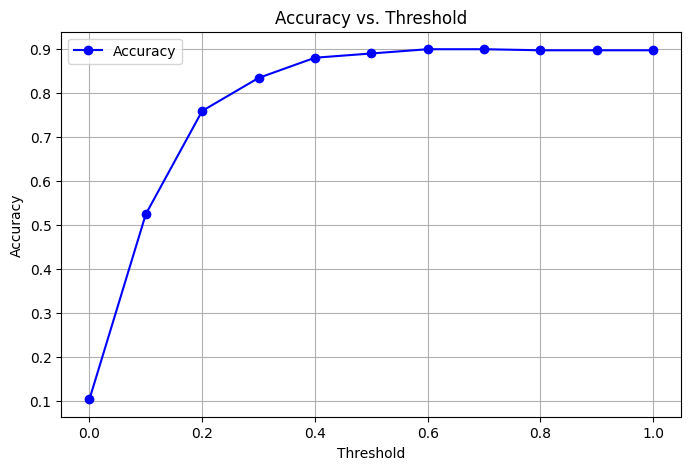

In [28]:
# chatgpt generated code which takes the accuracy/tpr at different thresholds and plots it, giving which threshold provides the highest accuracy (of course it levels off, so u don't want to go too far to the right on the plot)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

# Store accuracy values for plotting
accuracy_scores = []
thresholds_list = np.arange(0, 1.1, 0.1)

best_accuracy = 0
best_threshold = None
best_tpr = None

for threshold in thresholds_list:
    threshold = round(threshold, 1)

    # Binarize predictions
    predictions_binarized = [binarize_prediction(pred, threshold=threshold) for pred in predictions]

    # Compute Confusion Matrix & Extract Values
    tn, fp, fn, tp = confusion_matrix(Labels_test, predictions_binarized).ravel()

    # Compute Metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Avoid division by zero
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    accuracy = accuracy_score(Labels_test, predictions_binarized)

    # Store accuracy for plotting
    accuracy_scores.append(accuracy)

    # Track best threshold
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_tpr = tpr

    # Print Results
    print(f"\n Confusion Matrix, Threshold = {threshold}:")
    print(pd.DataFrame([[tn, fp], [fn, tp]], index=cm_labels_row, columns=cm_labels_col))
    print("True Positive Rate (TPR):", tpr)
    print("False Positive Rate (FPR):", fpr)
    print("Accuracy:", accuracy)

print(f"\nBest Threshold: {best_threshold}, Best Accuracy: {best_accuracy:.4f}, Best TPR: {best_tpr:.4f}")

# Plot Accuracy vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds_list, accuracy_scores, marker='o', linestyle='-', color='blue', label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Threshold")
plt.legend()
plt.grid()
plt.show()


<function accuracy_score at 0x7e1c6d57e520>
0.8099417037547797


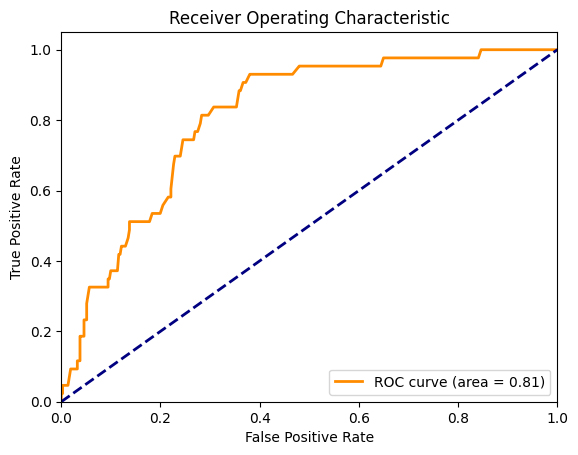

In [29]:
# Compute AUC
fpr, tpr, thresholds = roc_curve(Labels_test, predictions)
roc_auc = auc(fpr, tpr)

print(accuracy_score)
print(roc_auc)


# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [30]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.0
Specificity: 1.0


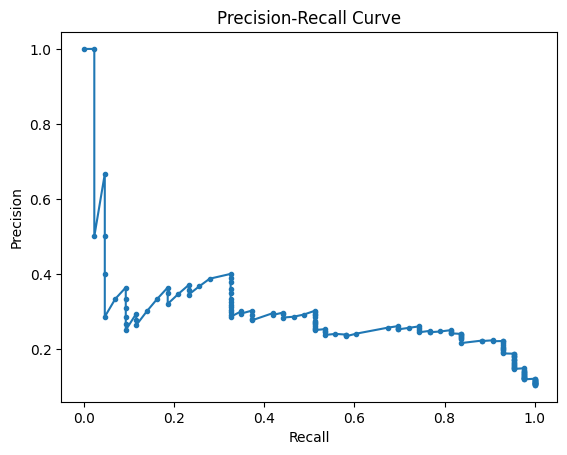

PRC-AUC =  0.2975600747309358


In [31]:
precision, recall, thresholds = precision_recall_curve(Labels_test, predictions)

prc_auc = auc(recall, precision)
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

print('PRC-AUC = ', prc_auc)

#Part 3: Making and interpretting model predictions

In [32]:
#Verify the model is loaded
print(model)

RandomForestClassifier(n_estimators=500, random_state=0)


In [33]:
#Load in prediction set
!wget https://raw.githubusercontent.com/GaryLiu152/3AB3_Antibiotics/main/final_assignment_data/prediction_set.csv


--2025-03-12 15:54:47--  https://raw.githubusercontent.com/GaryLiu152/3AB3_Antibiotics/main/final_assignment_data/prediction_set.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152007 (148K) [text/plain]
Saving to: ‘prediction_set.csv’

prediction_set.csv  100%[===================>] 148.44K  --.-KB/s    in 0.03s   

2025-03-12 15:54:47 (4.42 MB/s) - ‘prediction_set.csv’ saved [152007/152007]



In [34]:
#Preprocess the prediction set data
pred_data = pd.read_csv('prediction_set.csv')
remover = SaltRemover.SaltRemover(defnData="[Cl,Br]")
def canonicalize_smiles(smiles:str):
    mol = Chem.MolFromSmiles(smiles)
    stripped = remover.StripMol(mol)
    Chem.RemoveStereochemistry(stripped)
    return(Chem.MolToSmiles(stripped))
pred_data['SMILES'] = pred_data['SMILES'].apply(canonicalize_smiles)


In [35]:
#Calculate and save RDKit features
features_generator = rdNormalizedDescriptors.RDKit2DNormalized()

feature_vectors = []
for smile in tqdm(pred_data['SMILES'], total = len(pred_data), desc= 'Calculating Features'):
  mol_features = features_generator.process(smile)[1:]
  feature_vectors.append(mol_features)

assert len(feature_vectors) == len(pred_data)
pred_data['normalized_features'] = feature_vectors

Features = pred_data['normalized_features']
Features = pd.DataFrame(pred_data['normalized_features'].tolist(), columns=[f'normalized_features_{i+1}' for i in range(200)])
Features = Features.fillna(0)

Calculating Features: 100%|██████████| 2925/2925 [02:57<00:00, 16.45it/s]


In [36]:
import matplotlib.pyplot as plt
import numpy as np
# !pip install ipython-notebook
predictions = np.array([tree.predict(Features) for tree in model.estimators_])
predictions = np.mean(predictions, axis=0)
pred_data['model_predictions'] = predictions


ERROR: Could not find a version that satisfies the requirement ipython-notebook (from versions: none)
ERROR: No matching distribution found for ipython-notebook


0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
2920    0.794
2921    0.802
2922    0.820
2923    0.824
2924    0.872
Name: model_predictions, Length: 2925, dtype: float64


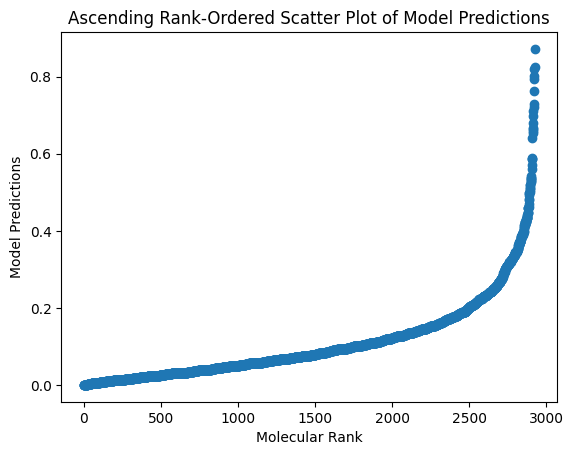

In [47]:
#plot predictions
pred_data.sort_values(by='model_predictions', ascending=True, inplace=True)
pred_data = pred_data.reset_index(drop=True)
print(pred_data['model_predictions'])

plt.scatter(pred_data.index, pred_data['model_predictions'])
plt.title('Ascending Rank-Ordered Scatter Plot of Model Predictions')
plt.xlabel('Molecular Rank')
plt.ylabel('Model Predictions')
plt.show()

#Save model predictions
pred_data.to_csv('assignment_predictions.csv', index=False, columns=['SMILES', 'model_predictions'])

Comparing to known antibiotic structures.

In [38]:
# You can ignore the session restart prompt.
!pip install chemfunc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: descriptastorus
    Found existing installation: descriptastorus 2.7.0.3
    Uninstalling descriptastorus-2.7.0.3:
      Successfully uninstalled descriptastorus-2.7.0.3


In [39]:
#Load in a set of known antibiotics (section 3.b)
!wget https://raw.githubusercontent.com/GaryLiu152/3AB3_Antibiotics/main/final_assignment_data/antibiotics_chembl.csv

--2025-03-12 15:58:11--  https://raw.githubusercontent.com/GaryLiu152/3AB3_Antibiotics/main/final_assignment_data/antibiotics_chembl.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120966 (118K) [text/plain]
Saving to: ‘antibiotics_chembl.csv’

antibiotics_chembl. 100%[===================>] 118.13K  --.-KB/s    in 0.03s   

2025-03-12 15:58:12 (4.00 MB/s) - ‘antibiotics_chembl.csv’ saved [120966/120966]



In [53]:
#Use chemfunc's 'nearest_neighbor' script to find the most similar molecule in
#'antibiotics_chembl' for each molecule in our prediction set

#Our predictions of molecules with potential to be hits were saved in the 'assignment_predictions.csv' file.
!chemfunc nearest_neighbor --data_path ./assignment_predictions.csv --reference_data_path ./antibiotics_chembl.csv --smiles_column SMILES

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.
Loading data
Computing similarities using tanimoto metric
morgan fingerprints: 100% 2925/2925 [00:01<00:00, 1803.74it/s]
morgan fingerprints: 100% 1007/1007 [00:00<00:00, 1097.86it/s]
Finding minimum distance SMILES
Saving


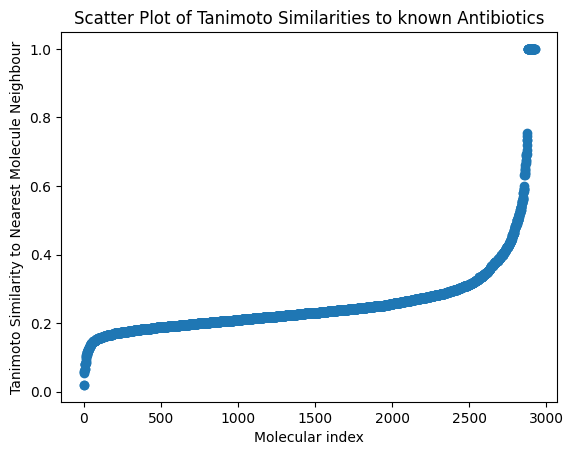

In [55]:
#Reload the prediction data and plot max similarities
pred_data = pd.read_csv('./assignment_predictions.csv')
pred_data = pred_data.sort_values(by='tanimoto_nearest_neighbor_similarity', ascending = True)
pred_data = pred_data.reset_index(drop=True)

plt.scatter(pred_data.index, pred_data['tanimoto_nearest_neighbor_similarity'])
plt.title('Scatter Plot of Tanimoto Similarities to known Antibiotics')
plt.xlabel('Molecular index')
plt.ylabel('Tanimoto Similarity to Nearest Molecule Neighbour')
plt.show()


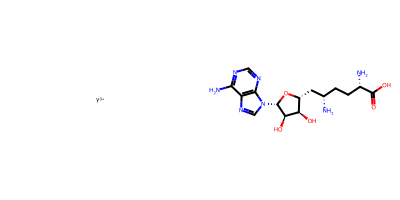

In [42]:
#what do the most common molecules look like?
from rdkit.Chem import Draw
from IPython.display import display

least_similar = pred_data.iloc[0]

least_similar_mols = [Chem.MolFromSmiles(least_similar['SMILES']), Chem.MolFromSmiles(least_similar['tanimoto_nearest_neighbor'])]

img = Draw.MolsToGridImage(least_similar_mols, molsPerRow=2, subImgSize=(200, 200), useSVG=True)

display(img)

SMILES                                    CC1(C)SCCN(S(=O)(=O)c2ccc(OCC#CCO)cc2)C1C(=O)NO
model_predictions                                                                     0.1
tanimoto_nearest_neighbor               CC1(C)S[C@@H]2[C@H](NC(=O)COc3ccccc3)C(=O)N2[C...
tanimoto_nearest_neighbor_similarity                                             0.256098
Name: 1999, dtype: object


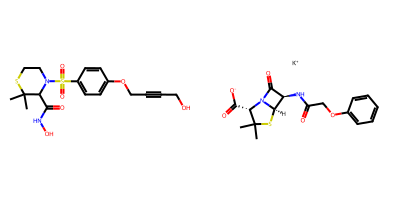

In [43]:
most_similar = pred_data.iloc[1999]
print(most_similar)

most_similar_mols = [Chem.MolFromSmiles(most_similar['SMILES']), Chem.MolFromSmiles(most_similar['tanimoto_nearest_neighbor'])]

img = Draw.MolsToGridImage(most_similar_mols, molsPerRow=2, subImgSize=(200, 200), useSVG=True)

display(img)

In [57]:
#Let's filter these 2000 predictions down to a reasonable number

#First by filtering potential analogues of known antibiotics
subset_similarity = pred_data[pred_data['tanimoto_nearest_neighbor_similarity'] < 0.4]
print(len(subset_similarity))

#Then by selecting the top predictions
subset_scores = subset_similarity[subset_similarity['model_predictions'] > 0.4]
print(len(subset_scores))

subset_scores.to_csv('./final_predictions.csv', index=False)


2707
67


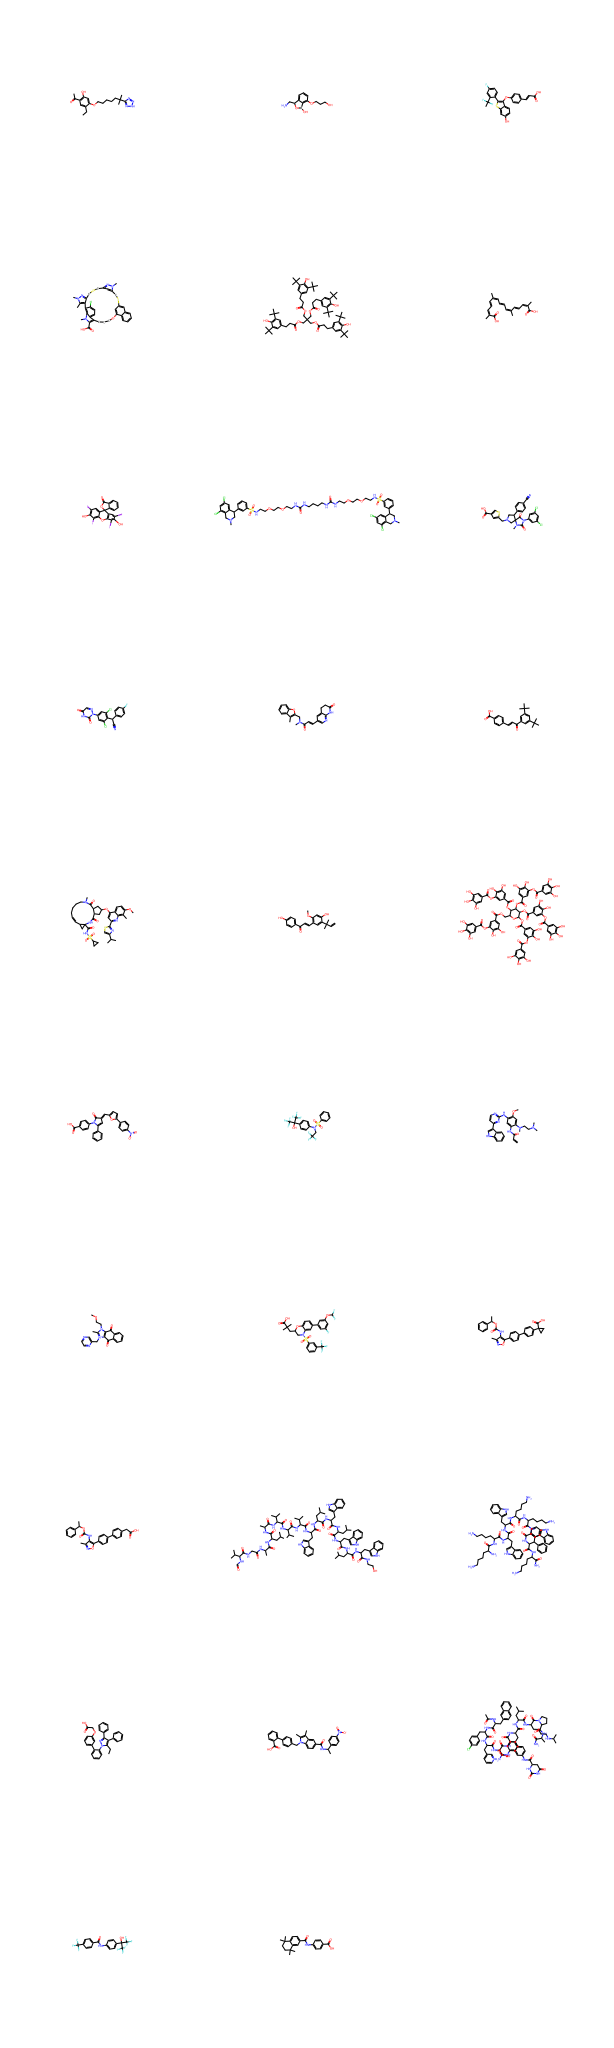

In [45]:
lead_smiles = subset_scores['SMILES']
lead_mols = [Chem.MolFromSmiles(smile) for smile in lead_smiles]

img = Draw.MolsToGridImage(lead_mols, molsPerRow=3, subImgSize=(400, 400), useSVG=True)
display(img)